# Auto-Encoder

In [28]:
# imports

import numpy as np

from matplotlib import pyplot as plt

from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader


# defs

In [36]:
def show_image(img):
    plt.clf()
    im = plt.imshow(img, cmap='jet', origin='lower')
    plt.colorbar(im)
    plt.show()

# Load up the data

In [4]:
images = np.load('SST_data.npy')

In [5]:
images.shape

(10000, 64, 64)

## Examine one

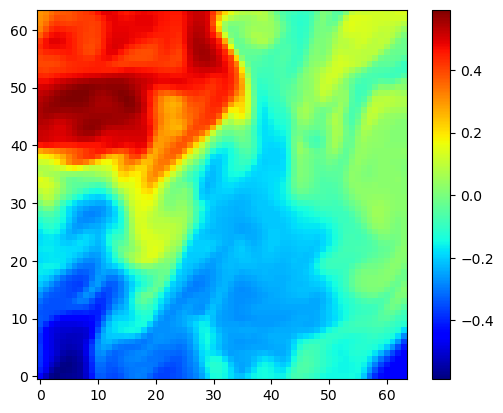

In [37]:
show_image(images[1000,...])

## Re-package

# DataSet and DataLoader

In [29]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)

In [32]:
dataset = MyDataset(images)
train_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

# AE Class

In [15]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

# Prep

In [18]:
ishape = 64**2
ishape

4096

In [22]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=ishape).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

# Train

In [35]:
epochs=10
for epoch in range(epochs):
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, ishape).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/10, loss = 0.170041
epoch : 2/10, loss = 0.154009
epoch : 3/10, loss = 0.149308
epoch : 4/10, loss = 0.146620
epoch : 5/10, loss = 0.144666
epoch : 6/10, loss = 0.142980
epoch : 7/10, loss = 0.143764
epoch : 8/10, loss = 0.141639
epoch : 9/10, loss = 0.140218
epoch : 10/10, loss = 0.139709


# Examine

In [38]:
idx = 1000

## Original

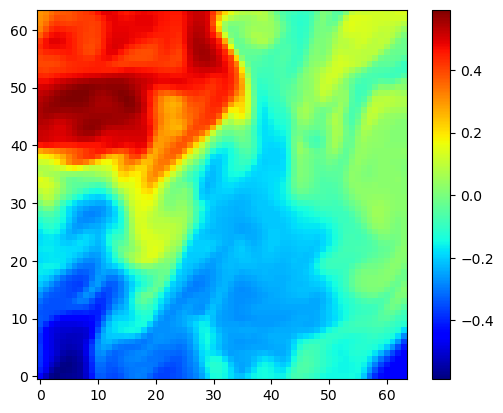

In [39]:
show_image(images[idx,...])

## Model it

----

In [23]:
my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])]

In [26]:
my_x[0].shape

(2, 2)